In [1]:
# Imports
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import Sequence

In [ ]:
# Modified to take list of image files as input
class DataGenerator(Sequence):
    def __init__(self, image_files, path='./neuralzome_crate_local/2024-01-31-09-51-48/rgb/', batch_size=16, shuffle=True):
        self.path = path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.images = image_files
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.images)

    def __getitem__(self, index):
        batch_files = self.images[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        keypoints = []

        for file in batch_files:
            img_path = os.path.join(self.path, file)
            yaml_path = os.path.join(self.path, file.replace('.jpg', '.yaml'))

            img = Image.open(img_path).convert('RGB')
            img = np.array(img).astype('float32') / 255.0

            with open(yaml_path, 'r') as f:
                crate = yaml.safe_load(f)['crates'][0]
            kp = np.array([
                crate['x0'], crate['y0'],
                crate['x1'], crate['y1'],
                crate['x2'], crate['y2'],
                crate['x3'], crate['y3']
            ], dtype='float32')

            images.append(img)
            keypoints.append(kp)

        return np.stack(images), np.stack(keypoints)


In [ ]:
# Valid files with annotations
all_files = []
path = './neuralzome_crate_local/2024-01-31-09-51-48/rgb/'
for file in sorted(os.listdir(path)):
    if file.endswith('.jpg'):
        yaml_path = os.path.join(path, file.replace('.jpg', '.yaml'))
        if os.path.exists(yaml_path):
            with open(yaml_path, 'r') as f:
                data = yaml.safe_load(f)
                if data.get('crates'):
                    all_files.append(file)

# Shuffle and split
np.random.shuffle(all_files)
total = len(all_files)
train_split = int(0.7 * total)
val_split = int(0.9 * total)

train_files = all_files[:train_split]
val_files = all_files[train_split:val_split]
test_files = all_files[val_split:]


In [4]:
train_gen = DataGenerator(train_files, path=path, batch_size=16, shuffle=True)
val_gen = DataGenerator(val_files, path=path, batch_size=16, shuffle=False)
test_gen = DataGenerator(test_files, path=path, batch_size=16, shuffle=False)

In [5]:
# Architecture of the Model - Input shape is (480, 640, 3)

model = models.Sequential([
    layers.Input(shape=(480, 640, 3)),

    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2),  # 240x320

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2),  # 120x160

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2),  # 60x80

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2),  # 30x40

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(8)  # 4 corner keypoints so 8 values (x0, y0, x1, y1, x2, y2, x3, y3) as output
])
    

In [ ]:
def keypoint_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=keypoint_loss,
    metrics=['mae']
)

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',        
    patience=5,                
    restore_best_weights=True, 
    verbose=1
)

history = model.fit(train_gen, validation_data=val_gen, epochs=100, callbacks=[early_stopping])

test_loss, test_mae = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 80171.0000 - mae: 242.5910 - val_loss: 39821.7773 - val_mae: 166.1862
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - loss: 21662.1367 - mae: 115.9364 - val_loss: 17549.0020 - val_mae: 103.0015
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - loss: 14463.5898 - mae: 94.7097 - val_loss: 13165.8447 - val_mae: 86.1791
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 8413.3340 - mae: 74.0084 - val_loss: 13186.6514 - val_mae: 87.1741
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - loss: 9149.8340 - mae: 75.4678 - val_loss: 14298.7529 - val_mae: 89.9417
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - loss: 8762.9619 - mae: 74.0836 - val_loss: 11986.9189 - val_mae: 81.5544
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - loss: 8877.1270 - mae: 74.3955 - val_loss: 12094.3408 - val_mae: 82.4755
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - loss: 8029.5796 - mae: 69.9872 - val_loss: 12491.8516 - val_mae: 82.0711
Epoch 9/100
6/

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


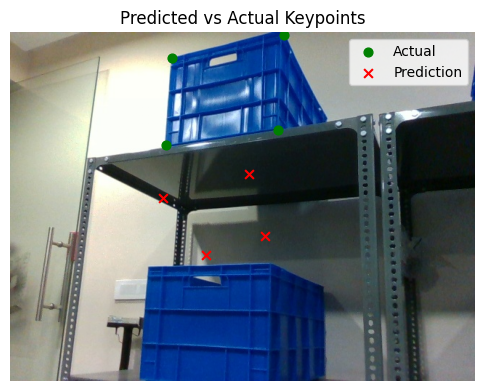

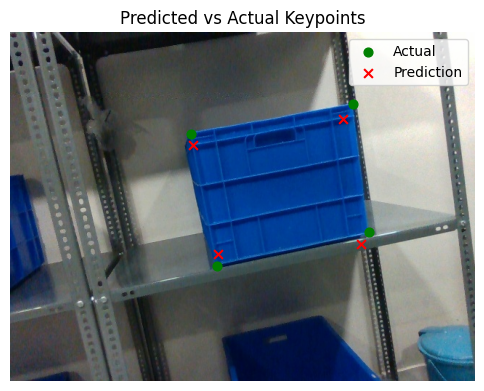

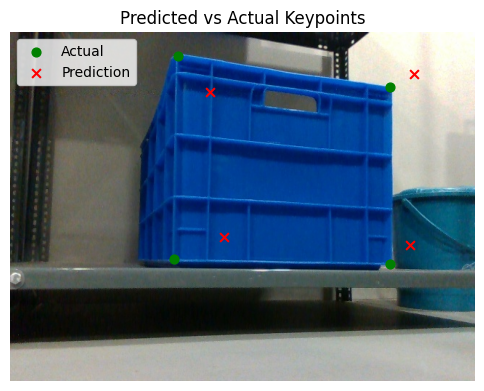

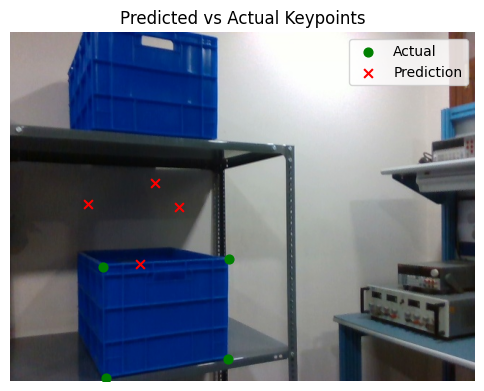

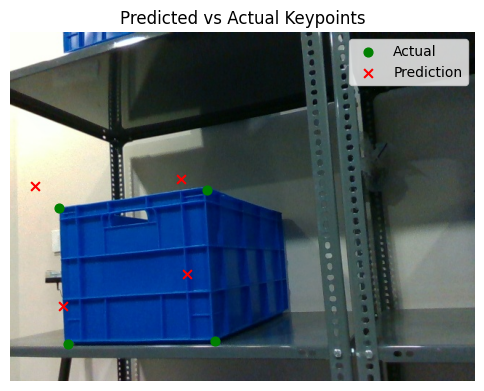

ValueError: need at least one array to stack

In [7]:
def visualize_predictions(model, generator, num_images=5):

    for i in range(num_images):
        images, keypoints_true = generator[i]
        preds = model.predict(images)

        for j in range(min(len(images), num_images)):
            img = images[j]
            true_kp = keypoints_true[j].reshape(-1, 2)
            pred_kp = preds[j].reshape(-1, 2)

            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.scatter(true_kp[:, 0], true_kp[:, 1], c='green', label='Actual', s=40)
            plt.scatter(pred_kp[:, 0], pred_kp[:, 1], c='red', marker='x', label='Prediction', s=40)
            plt.legend()
            plt.title("Predicted vs Actual Keypoints")
            plt.axis('off')
            plt.show()

visualize_predictions(model, test_gen, num_images=5)

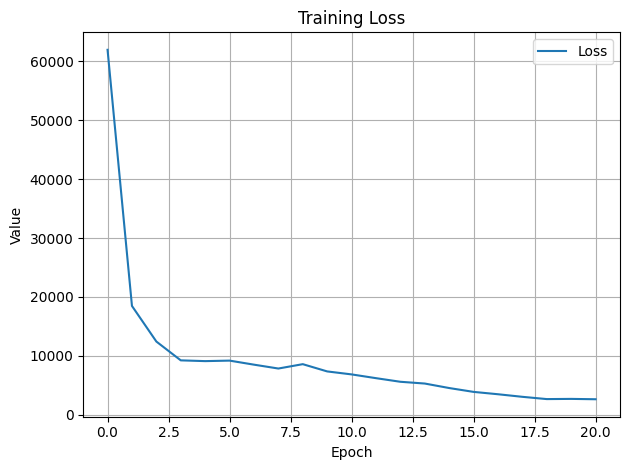

In [9]:
plt.figure()
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

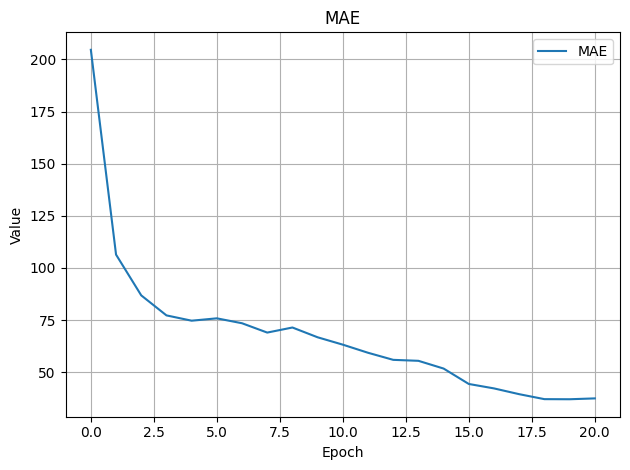

In [10]:
plt.figure()
plt.plot(history.history['mae'], label='MAE')
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

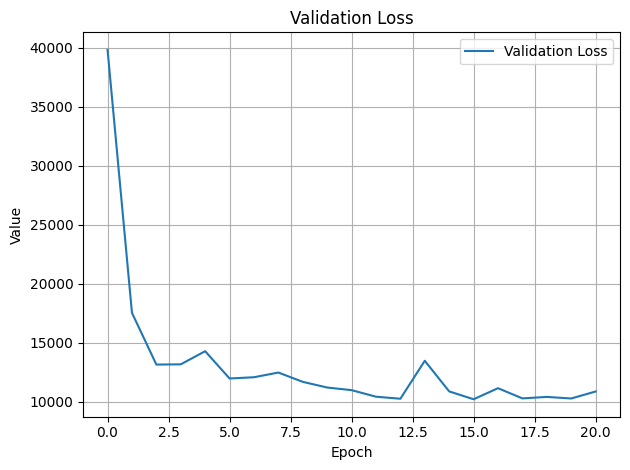

In [11]:
plt.figure()
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

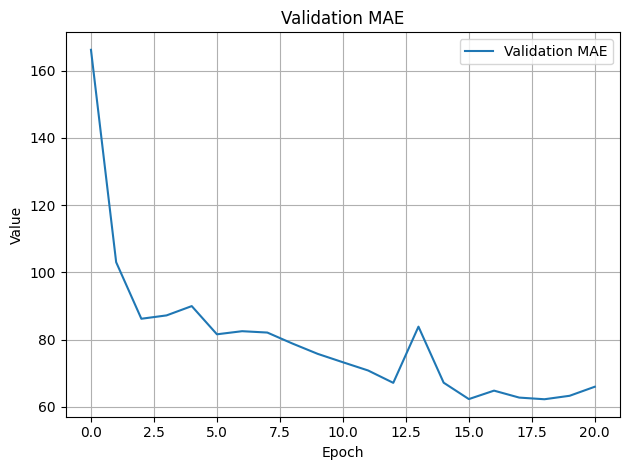

In [12]:
plt.figure()
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()